# Figure 6: overview of MHC II genotyping

# Set up

In [1]:

# imported packages
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import matplotlib.ticker as plticker
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib.patches import Polygon
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib import cm
import scipy.special
import scipy.integrate as it
from scipy import integrate
from scipy.interpolate import interp1d
from scipy.stats import kde
import copy
import glob, os
import re
# from sklearn import datasets, linear_model
import pandas as pd
from decimal import *
from operator import itemgetter    
from collections import OrderedDict
import timeit
import time 
import csv
import seaborn as sns 
import scipy as sp
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from itertools import combinations
from scipy.stats import kruskal
from scipy.stats import mannwhitneyu
from matplotlib.backends.backend_pdf import PdfPages
import statsmodels.api as sm
import plotly.express as px
import kaleido



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Lists of colors for plots
c0 = (0.76, 0.76, 0.76)
c1 = (1.00, 0.18, 0.33);
c2 = (1.00, 0.23, 0.19);
c3 = (1.00, 0.58, 0.00);
c4 = (1.00, 0.80, 0.00);
c5 = (0.30, 0.85, 0.39);
c6 = (0.35, 0.78, 0.98);
c7 = (0.20, 0.67, 0.86);
c8 = (0.00, 0.48, 1.00);
c9 = (0.35, 0.34, 0.84);
c10 = (0.00, 0.31, 0.57);
c11 = (0.12, 0.29, 0.69);
c12 = (0.17, 0.17, 0.42);
c13 = (1.00, 1.00, 1.00);
c14 = (0.77, 0.04, 0.00);
#define the colors from colorbrewer2
orange1 = '#feedde'
orange2 = '#fdbe85'
orange3 = '#fd8d3c'
orange4 = '#e6550d'
orange5 = '#a63603'
blue0 = '#31bdb2'
blue1 = '#eff3ff'
blue2 = '#bdd7e7'
blue3 = '#6baed6'
blue4 = '#3182bd'
blue5 = '#08519c'
green1 = '#edf8e9'
green2 = '#bae4b3'
green3 = '#74c476'
green4 = '#31a354'
green5 = '#006d2c'
grey1 = '#f7f7f7'
grey2 = '#cccccc'
grey3 = '#969696'
grey4 = '#636363'
grey5 = '#252525'
purple0 = '#6c31bd'
purple1 = '#f2f0f7'
purple2 = '#cbc9e2'
purple3 = '#9e9ac8'
purple4 = '#756bb1'
purple5 = '#54278f'
red1 = '#fee5d9'
red2 = '#fcae91'
red3 = '#fb6a4a'
red4 = '#de2d26'
red5 = '#a50f15'
# yellow = '#ffffd4'

In [3]:
# set up plotting parameters 
axisfont=11
titlefont=20
subtitlefont = 15
axislabelfont=12
legendfont = 11
tpfont = 12
plt.rcParams.update({'font.sans-serif':'Arial'})

In [4]:
# get current date 
timestr = time.strftime("%Y%m%d") 

# Import UKBB data

In [5]:

# Import all the data (all calls: include singletons and higher read numbers, for all changes at a position affected in CH)

# path to ukb files from Hamish 
folder_path = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ukb_hotspot_calls_annotated'  

# get all files in the folder 
files = glob.glob(os.path.join(folder_path, '*.txt'))  
# print('Files examined are:', files)

# initialize an empty dictionary 
dataframes = {}

# iterate through the CSV files and read each one with pandas
for csv_file in files:
    
    df = pd.read_csv(csv_file, sep = '\t')
    dataframes[csv_file] = df

# extract dataframes 
for file_name, df in dataframes.items():
    
    # construct variable names dynamically based on file names
    variable_name = file_name.split('/')[8].split('.')[0] + '_data'  # Removing the file extension
    print('Examined file:', variable_name)
    
    df['batch'] = variable_name # add column to indicate source 
    globals()[variable_name] = df  # assign df to a variable with the file name


# concat all into one df
dfs_to_concat = [v for k, v in globals().items() if k.endswith('_data') and isinstance(v, pd.DataFrame)]

# combine all dfs into one 
batch_all = pd.concat(dfs_to_concat, ignore_index=True)
batch_all = batch_all.dropna(subset=['batch']) # remove rows which are read incorrectly (w/o batch number)

# rename column
batch_all = batch_all.rename(columns={'sample_ID': 'Person_ID'})

print('Number of samples with variants examined:', batch_all.shape[0])

Examined file: batch_21_annotated_data
Examined file: batch_18_annotated_data
Examined file: batch_15_annotated_data
Examined file: batch_11_annotated_data
Examined file: batch_16_annotated_data
Examined file: batch_12_annotated_data
Examined file: batch_13_annotated_data
Examined file: batch_17_annotated_data
Examined file: batch_14_annotated_data
Examined file: batch_19_annotated_data
Examined file: batch_20_annotated_data
Number of samples with variants examined: 76718


In [6]:

# change numerical variables to integers
batch_all['end_position'] = batch_all['end_position'].astype(int)
batch_all['position'] = batch_all['position'].astype(int)
batch_all['Person_ID'] = batch_all['Person_ID'].astype(int)

# view the data
batch_all.head(n = 5)

,Person_ID,chromosome,position,end_position,ref,alt,depth,var_depth,VAF,variant_type,...,EXON,GIVEN_REF,IMPACT,INTRON,STRAND,SYMBOL,SYMBOL_SOURCE,USED_REF,VARIANT_CLASS,batch
0,2100020,chr17,7674230,7674230,C,A,32,1,0.031250,SNV,...,7/11,C,MODERATE,-,-1.0,TP53,EntrezGene,C,SNV,batch_21_annotated_data
1,2100020,chr17,7675088,7675088,C,T,54,1,0.018519,SNV,...,5/11,C,MODERATE,-,-1.0,TP53,EntrezGene,C,SNV,batch_21_annotated_data
2,2100033,chr2,25234307,25234307,G,T,85,1,0.011765,SNV,...,23/23,G,MODERATE,-,-1.0,DNMT3A,EntrezGene,G,SNV,batch_21_annotated_data
3,2100071,chr2,25240439,25240439,G,A,92,1,0.010870,SNV,...,19/23,G,MODERATE,-,-1.0,DNMT3A,EntrezGene,G,SNV,batch_21_annotated_data
4,2100071,chr2,25240439,25240439,G,T,92,1,0.010870,SNV,...,19/23,G,LOW,-,-1.0,DNMT3A,EntrezGene,G,SNV,batch_21_annotated_data


In [7]:

# Import indexes tested in each batch 

# path to ukb files from Hamish 
folder_path = '/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ukb_hotspot_calls/batch_ids'  

# get all files in the folder 
files_ids = glob.glob(os.path.join(folder_path, '*.tsv'))  

# initialize an empty dictionary
indexes = {}

# Iterate through the CSV files and read each one with pandas
for file in files_ids:
    
    id = pd.read_csv(file, sep = '\t')
    id = id.rename(columns={'batch ID': 'Person_ID'})
    id['Person_ID'] = id['Person_ID'].str.split('_', n = 1).str[0]
    indexes[file] = id

for file_name, df in indexes.items():

    # construct variable names dynamically based on file names
    variable_name = file_name.split('/')[9].split('.')[0] # remove file extension
    globals()[variable_name] = df  # assign the df to a variable with the file name


# Annotate UKBB cases with CH variant carried

In [8]:

# The data that I imported is annotated but has not been filtered to only include variants that are present in CH

# prepare the dataframe for annotation
batch_all['end_position'] = batch_all['end_position'].astype(int)
batch_all['Person_ID'] = batch_all['Person_ID'].astype(int)

# subset and create new useful columns
batch_all = batch_all[['Person_ID', 'chromosome', 'end_position', 'VAF', 'var_depth', 'depth', 'Amino_acids', 'SYMBOL', 'Codons', 'batch']]
batch_all['alt'] = batch_all['Amino_acids'].str.split('/', expand = True)[1]
batch_all['ref'] = batch_all['Amino_acids'].str.split('/', expand = True)[0]

# create column with coordinates such that you can merge annotation (on genetic variant name)
batch_all['variant_coord'] = batch_all['chromosome'].astype(str) + "_" + batch_all['end_position'].astype(str) 
batch_all['variant_coord'] = batch_all['variant_coord'].astype('category')

# create column with coordinates, gene affected and specific variant 
batch_all['variant_coord_pos'] = batch_all['variant_coord'].astype(str) +  "_" + batch_all['SYMBOL'].astype(str) + "_" + batch_all['ref'].astype(str) + "_" + batch_all['alt'].astype(str)
batch_all['variant_coord_pos'] = batch_all['variant_coord_pos'].astype('category')

# view added columns
batch_all.head(n = 5)

# NOTE: in some cases, the amino acid column only contains a single aa value
# that does NOT indicate that there was a nonsense mutation (ie STOP codon introduced)
# STOP codons ARE indicated in the dataframe with "*"

,Person_ID,chromosome,end_position,VAF,var_depth,depth,Amino_acids,SYMBOL,Codons,batch,alt,ref,variant_coord,variant_coord_pos
0,2100020,chr17,7674230,0.031250,1,32,G/C,TP53,Ggc/Tgc,batch_21_annotated_data,C,G,chr17_7674230,chr17_7674230_TP53_G_C
1,2100020,chr17,7675088,0.018519,1,54,R/H,TP53,cGc/cAc,batch_21_annotated_data,H,R,chr17_7675088,chr17_7675088_TP53_R_H
2,2100033,chr2,25234307,0.011765,1,85,P/Q,DNMT3A,cCg/cAg,batch_21_annotated_data,Q,P,chr2_25234307,chr2_25234307_DNMT3A_P_Q
3,2100071,chr2,25240439,0.010870,1,92,R/W,DNMT3A,Cgg/Tgg,batch_21_annotated_data,W,R,chr2_25240439,chr2_25240439_DNMT3A_R_W
4,2100071,chr2,25240439,0.010870,1,92,R,DNMT3A,Cgg/Agg,batch_21_annotated_data,None,R,chr2_25240439,chr2_25240439_DNMT3A_R_None


In [9]:

# import coordinate data (df created manually based on COSMIC)
coord_gene_var = pd.read_csv('/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/ch_variants_coordinates_tp53_added_nts.csv')

# create required columns
coord_gene_var['variant_coord'] = coord_gene_var['chromosome'] + "_" + coord_gene_var['end_position'].astype(str) # find cariant coordinates
coord_gene_var['SYMBOL'] = coord_gene_var['gene_var'].str.split('_').str[0] # find gene analysed
coord_gene_var['ref'] = coord_gene_var['gene_var'].str.split('_').str[1].str[0] # reference sequence variant 
coord_gene_var['alt'] = coord_gene_var['gene_var'].str.split('_').str[1].str[-1] # alternative sequence (CH / mutation) variant
coord_gene_var['variant_coord_pos'] = coord_gene_var['variant_coord'].astype(str) + "_" + coord_gene_var['SYMBOL'].astype(str) + "_" + coord_gene_var['ref'].astype(str) + "_" + coord_gene_var['alt'].astype(str) # specific mutation 

print('Number of variants which have been investigated:', len(coord_gene_var.variant_coord_pos.unique()))
print('Number of sites which have been investigated:',len(coord_gene_var.variant_coord.unique()))

Number of variants which have been investigated: 42
Number of sites which have been investigated: 36


In [10]:
# Annotation

# subset required columns
gene_vars = coord_gene_var[['variant_coord_pos', 'gene_var']]

# subset batch df to only include variants which were successfully identified 
batch_gene_vars = pd.merge(batch_all, gene_vars, on = 'variant_coord_pos', how = 'inner')
batch_gene_vars['gene_var'] = batch_gene_vars['gene_var'].astype('category')
batch_gene_vars['gene_var'].value_counts()

gene_vars_count = pd.DataFrame(batch_gene_vars['gene_var'].value_counts())
gene_vars_count['gene_var'] = gene_vars_count.index
gene_vars_count = gene_vars_count.reset_index(drop=True)
gene_vars_sorted = gene_vars_count.sort_values(by = 'count', ascending=False)

print('Number of variants identified with annotations:', gene_vars_sorted.shape[0])
# so we will have 30 variants to look at bc the rest was not mapped correctly 

print('Number of samples examined:', batch_all.shape[0])
print('Number of patients examined:', len(batch_all.Person_ID.unique()))
print('Number of samples with annotated variants:', batch_gene_vars.shape[0])
print('Number of patients with annotated variants:', len(batch_gene_vars.Person_ID.unique()))

# NOTE
# I will carry out further analysis on batch_gene_vars dataframe (= contains samples with reads with CH-specific variants)
# I am working on a df that is not filtered with respect to read number (ie retaining singletons)

Number of variants identified with annotations: 38
Number of samples examined: 76718
Number of patients examined: 52356
Number of samples with annotated variants: 40752
Number of patients with annotated variants: 33377


# Import MHC class II allele data

In [12]:

# path to file
file_hla = "/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/UKBB/ukb_typed_hla_with_ids_07_threshold_processed.txt"

# get the header 
header = pd.read_csv(file_hla, sep='\t', nrows=1, header=None).values.tolist()
head = [item for sublist in header for item in sublist]

# get the actual dataframe 
df = pd.read_csv(file_hla, skiprows = 1, sep = ' ', header = None)

# add columns 
df.columns = head 

# subset data for HLA-I and HLA-II class alleles 
# we are only interested in HLA-I for the momnet 
df_hla1 = df.filter(regex='^(Person_|A_|B_|C_)') # 488377 cases 
df_hla2 = df.filter(regex='^(Person_|D)') # 488377 cases 

# we will analyse DR and DP / DQ alleles separately because the "rules" are different (ie alpha / beta chain combinations etc.)
df_hla2_dp = df_hla2.filter(regex='^(Person_|DP)')
df_hla2_dq = df_hla2.filter(regex='^(Person_|DQ)')
df_hla2_drb1 = df_hla2.filter(regex='^(Person_|DRB1)')
df_hla2_drball = df_hla2.filter(regex='^(Person_|DRB)')

# note that here we are ignoring DRB3, DRB4, DRB5 - can investigate later
# DRB3, 4, 5 are expressed at levels several fold lower than DRB1, so for now we can expect they will have a minor influence on presentation as compared to DRB1
# DRB3, 4, 5 are only present in a subset of population (can look into whether having them affects CH risk etc but let's do this later on)

# change 0.5 to 0 to be clear on what alleles you are typing
df_clean_hla2_dp = df_hla2_dp[~df_hla2_dp.isin([0.5]).any(axis=1)] # exclude people for whom we lacked a genotype
df_clean_hla2_dp = df_clean_hla2_dp[~df_clean_hla2_dp.isin([1.5]).any(axis=1)] # exclude people for whom we lacked a genotype
df_clean_hla2_dq = df_hla2_dq[~df_hla2_dq.isin([0.5]).any(axis=1)] # exclude people for whom we lacked a genotype
df_clean_hla2_dq = df_clean_hla2_dq[~df_clean_hla2_dq.isin([1.5]).any(axis=1)] # exclude people for whom we lacked a genotype
df_clean_hla2_drb1 = df_hla2_drb1[~df_hla2_drb1.isin([0.5]).any(axis=1)] # exclude people for whom we lacked a genotype
df_clean_hla2_drb1 = df_clean_hla2_drb1[~df_clean_hla2_drb1.isin([1.5]).any(axis=1)] # exclude people for whom we lacked a genotype
df_clean_hla2_drball = df_hla2_drball[~df_hla2_drball.isin([0.5]).any(axis=1)] # exclude people for whom we lacked a genotype
df_clean_hla2_drball = df_clean_hla2_drball[~df_clean_hla2_drball.isin([1.5]).any(axis=1)] # exclude people for whom we lacked a genotype

print("Number of samples with HLA genotype available:", df_hla2.shape[0])

# remove DRB3_9901, DRB4_9901, DRB5_9901 - these columns indicate people who do NOT have an allele so they should not be included when you sum things up
# this can also artificially drive the impression that some alleles are common when actually not having them is more common
cols_to_drop = ['DRB3_9901', 'DRB4_9901', 'DRB5_9901']
df_hla2 = df_hla2.drop(columns=cols_to_drop)

# create a new df where we ignore DRB3, DRB4 and DRB5 altogether 
filtered_col = df_hla2.filter(regex='^(?!DRB3|DRB4|DRB5)').columns
df_hla2_1 = df_hla2[filtered_col]


Number of samples with HLA genotype available: 488377


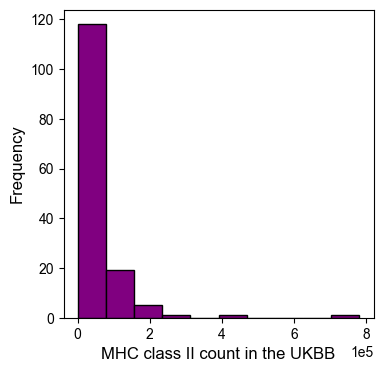

In [15]:

# MHC class II alleles distribution
columns_to_sum = df_hla2.filter(regex='\d').columns # select columns that have some numbers in 
sum_values = df_hla2[columns_to_sum].sum(axis=0) # sum values in each column
result_df = pd.DataFrame({'Sum': sum_values}) # create new df

plt.figure(figsize = (4,4))
plt.hist(result_df['Sum'], edgecolor='black', color = '#800080')

# Adding labels and title
plt.xlabel('MHC class II count in the UKBB', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure6/{timestr}/{timestr}_histogram_MHCII_allele_frequencies_in_UKBB_all_cases.pdf', bbox_inches='tight')

# conclusion: most alleles are rare but there are some alleles that are extremely common

In [42]:
result_df[result_df.Sum > 700000]

,Sum
DPA1_103,781022.5


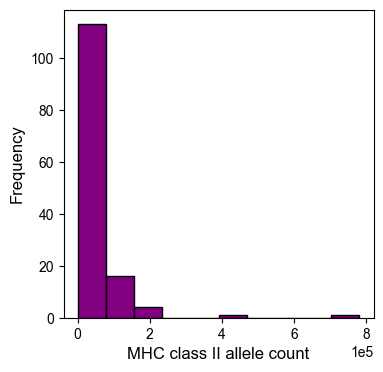

In [17]:

# only with DRB1 out of all the DRB alleles
columns_to_sum = df_hla2_1.filter(regex='\d').columns # select columns that have some numbers in 
sum_values = df_hla2_1[columns_to_sum].sum(axis=0) # sum values in each column
result_df = pd.DataFrame({'Sum': sum_values}) # create new df



plt.figure(figsize = (4,4))
plt.hist(result_df['Sum'], edgecolor='black', color = '#800080')

# Adding labels and title
plt.xlabel('MHC class II allele count', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure6/{timestr}/{timestr}_histogram_MHCII_allele_frequencies_in_UKBB_all_cases.pdf', bbox_inches='tight')


In [36]:

# define a function to plot the distribution of the number of typed alleles 

def plot_MHCII_typing(low, up, df, color, edgecolor, name):
    
    plt.figure(figsize = (4,4))
    plt.bar(range(low, up), df, width=1, align='center', color=color, edgecolor=edgecolor)

    plt.ylabel('Frequency', fontsize = 12)
    plt.yticks(fontsize = 10)  

    plt.xlabel('Number of typed MHC II alleles', fontsize = 12)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.xticks(range(low, up), fontsize = 10)
    plt.xlim(0,up)
    plt.yticks(fontsize = 10)
    plt.yticks([0, 1*10**5, 2*10**5, 3*10**5, 4*10**5, 5*10**5])
    plt.ylim(0, 5*10**5)
    # plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure6/{timestr}/{timestr}_histogram_MHCII_allele_typing_in_UKBB_{name}.pdf', bbox_inches='tight')

In [19]:

# alleles correctly typed in EVERYONE in the UKBB (regardless of if they have CH or not)
# looking at DRB1 only (no DRB3, 4, or 5)

df_hla2_1['typed_hla'] = df_hla2_1.iloc[:,1:].sum(axis=1)
print(max(df_hla2_1['typed_hla'])) # should be 10!
hla_14_typed_all = (df_hla2_1['typed_hla'] == 9).sum() # 7
hla_15_typed_all = (df_hla2_1['typed_hla'] == 10).sum() # 71
sum_typed_hla_all = df_hla2_1['typed_hla'].to_list()
counts_all = [sum_typed_hla_all.count(value) for value in range(1, 11)]


10.0


/var/folders/pm/9pk2smx14xgfsh10_fdyd_w00000gn/T/ipykernel_49679/3096645378.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hla2_1['typed_hla'] = df_hla2_1.iloc[:,1:].sum(axis=1)


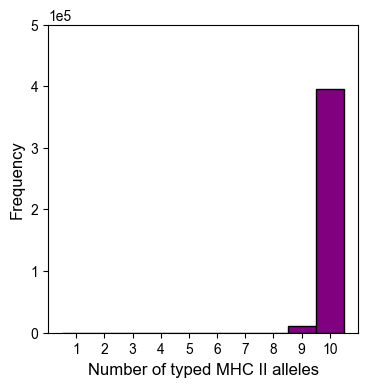

In [37]:
## plot
plot_MHCII_typing(1, 11, counts_all, '#800080', 'black', 'MHCII_typed_cases_UKBB_all')

In [21]:
# add MHC genotype data to CH cases (with annotated variants and scores)
batch_gene_hla = pd.merge(batch_gene_vars, df_hla2_1, on = 'Person_ID') 
print('Number of CH samples for which MHCII genotype is available:', batch_gene_hla.shape[0])

Number of CH samples for which MHCII genotype is available: 40704


In [22]:

# all alleles typed (NOTE that this will also include alleles for which you do not have scores from NetMHCpan / PRIME etc)
# here, I am looking only at people who would be considered CH cases (CH variant identified in sequencing data)

sum_typed_hla_ch = batch_gene_hla['typed_hla'].to_list()
counts_ch = [sum_typed_hla_ch.count(value) for value in range(1, 11)]


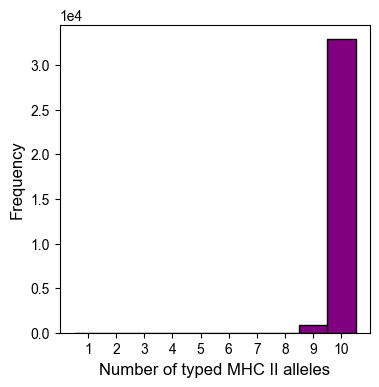

In [23]:
# number of typed alleles with available predictions 
plot_MHCII_typing(1, 11, counts_ch, '#800080', 'black', 'MHC_typed_cases_UKBB_CH')


/var/folders/pm/9pk2smx14xgfsh10_fdyd_w00000gn/T/ipykernel_49679/3833747138.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_entries['percent'] = top_10_entries['Sum'] / df_hla2.shape[0] * 100


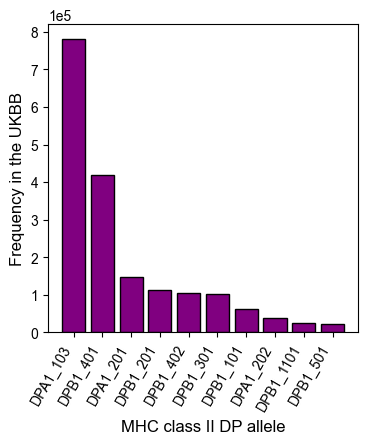

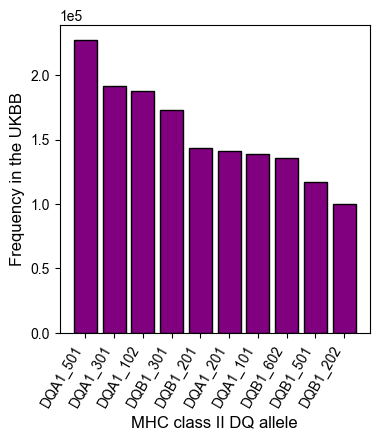

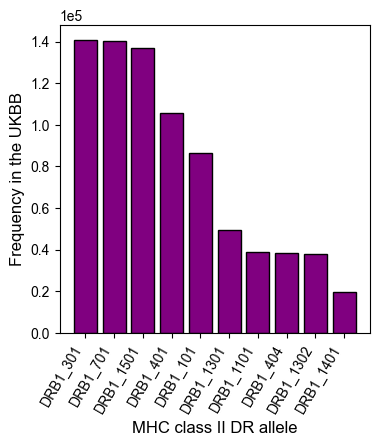

In [25]:

# find top 10 DP, DQ, DR alleles by total number of typed alleles 

result_df_reset = result_df.reset_index()
result_df_sorted = result_df_reset.sort_values(by=['index', 'Sum'])
result_df_sorted['cat'] = result_df_sorted['index'].str.split('_').str.get(0)
result_df_sorted['cat'] = result_df_sorted['cat'].str[:2]

# Get the top 10 HLA DP, DQ, DR by the total number of these alleles typed 
top_names = result_df_sorted.sort_values(by=['cat', 'Sum'], ascending = False)
top_10_entries = top_names.groupby('cat').head(10)
top_10_entries['percent'] = top_10_entries['Sum'] / df_hla2.shape[0] * 100

categories = ['DP', 'DQ', 'DR']
for cat in categories:
    df = top_10_entries[top_10_entries['cat'] == cat]
    plt.figure(figsize=(4, 4))
    plt.bar(df['index'], df['Sum'], color = '#800080', edgecolor = 'black')
    plt.xlabel(f'MHC class II {cat} allele', fontsize = 12)
    plt.xticks(rotation=60, ha='right')
    plt.ylabel('Frequency in the UKBB', fontsize = 12)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure6/{timestr}/{timestr}_barchart_MHCII_allele_top10_in_UKBB_{cat}.pdf', bbox_inches='tight')


/var/folders/pm/9pk2smx14xgfsh10_fdyd_w00000gn/T/ipykernel_49679/2685008002.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_entries_count['percent'] = top_10_entries_count['Count'] / df_hla1.shape[0] * 100


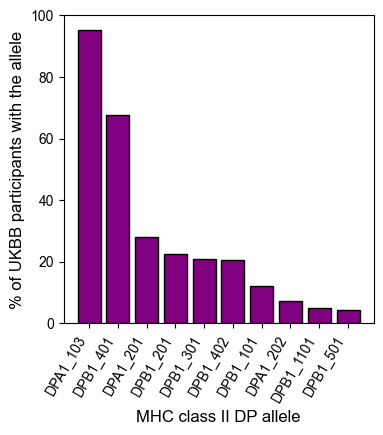

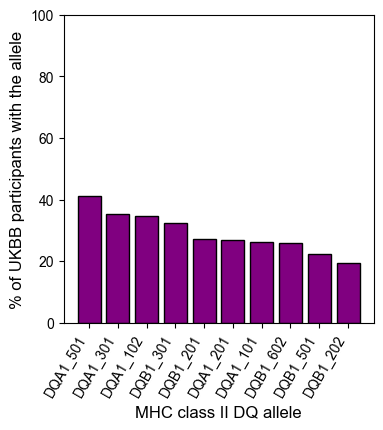

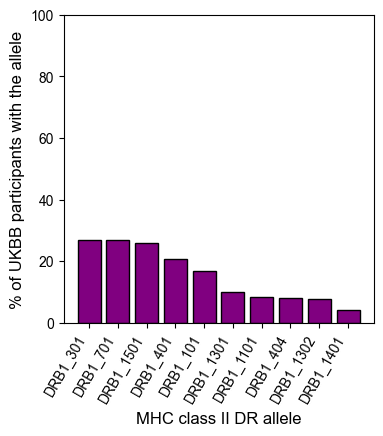

In [29]:

# find top 10 A, B, C alleles by the number of people they are present in (not the total allele count = note that each allele can be present in two copies)
# so the total nr of copies of allele X in the population vs number of people who carry allele X are not the same thing

columns_to_sum = df_hla2_1.filter(regex='\d').columns
count_values = (df_hla2_1[columns_to_sum] != 0).sum(axis=0) # sum values in each column
count_mhc_df = pd.DataFrame({'Count': count_values}) # create new df

count_mhc_df_reset = count_mhc_df.reset_index()
count_mhc_df_sorted = count_mhc_df_reset.sort_values(by=['index', 'Count'])
count_mhc_df_sorted['cat'] = count_mhc_df_sorted['index'].str.split('_').str.get(0)
count_mhc_df_sorted['cat'] = count_mhc_df_sorted['cat'].str[:2]

# Get the top 10 names in each category
top_names_count = count_mhc_df_sorted.sort_values(by=['cat', 'Count'], ascending = False)
top_10_entries_count = top_names_count.groupby('cat').head(10)
top_10_entries_count['percent'] = top_10_entries_count['Count'] / df_hla1.shape[0] * 100

categories = ['DP', 'DQ', 'DR']
for cat in categories:
    df = top_10_entries_count[top_10_entries_count['cat'] == cat]
    plt.figure(figsize=(4, 4))
    plt.bar(df['index'], df['percent'], color = '#800080', edgecolor = 'black')
    plt.xlabel(f'MHC class II {cat} allele', fontsize = 12)
    plt.xticks(rotation=60, ha='right')
    plt.ylabel('% of UKBB participants with the allele', fontsize = 12)
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    plt.ylim(0, 100)
    plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure6/{timestr}/{timestr}_barchart_MHC_allele_top10_in_UKBB_{cat}_fraction.pdf', bbox_inches='tight')


# Distribution of scores in the dataset

In [43]:
# Load the scores 
# load scores from NetMHC II 

# parameters
param = '%Rank_EL' # let's do it on EL ranks first 

# NOTE: In the original file (sub), I was missing a score for DNMT3A_R736C_ch so I generated it separately with the same code and will concatenate the files here 
# load the file with binding predictions across variants
pred_file_dpq_sub = "/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/NetMHCII_out/scores/20240211_NetMHC_HLA_UKBB_with_affinities_DP_DQ_bestscores.csv"
pred_file_dpq_r736c = "/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/NetMHCII_out/scores/20240215_NetMHC_HLA_UKBB_with_affinities_DP_DQ_R736C_bestscores.csv"
pred_file_dpq_stop = "/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/NetMHCII_out/scores/20240214_NetMHC_HLA_UKBB_with_affinities_DP_DQ_stopcodons_bestscores.csv"
pred_method = pred_file_dpq_sub.split('_out')[0] # all are with the same method so does not matter which file you end up using 
 
# organize file with prediction scores for DP and DQ alleles 
pred_filename_dpq_sub = pred_file_dpq_sub.split('/')[2].split('.')[0]
pred_filename_dpq_stop = pred_file_dpq_stop.split('/')[2].split('.')[0]
pred_df_dpq_sub = pd.read_csv(pred_file_dpq_sub)
pred_df_dpq_r736c = pd.read_csv(pred_file_dpq_r736c)
pred_df_dpq_stop = pd.read_csv(pred_file_dpq_stop)

# In the sub file, I had some predictions for STOP-codon-containing variants, I don't want these so remove them
pred_df_dpq_sub = pred_df_dpq_sub[~pred_df_dpq_sub['gene_var'].str.contains('\*')]

# concat the files 
pred_df_dpq = pd.concat([pred_df_dpq_sub, pred_df_dpq_stop, pred_df_dpq_r736c], ignore_index = True)
pred_df_dpq['gene_var_gt'] = pred_df_dpq['gene'] + '_' + pred_df_dpq['variant'] + '_' + pred_df_dpq['genotype'] # create a column that includes all genotype data

# organize file with prediction scores for DR alleles 
pred_file_dr_sub = "/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/NetMHCII_out/scores/20240214_NetMHC_HLA_UKBB_with_affinities_DR_bestscores.csv"
pred_file_dr_r736c = "/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/NetMHCII_out/scores/20240215_NetMHC_HLA_UKBB_with_affinities_DR_R736C_bestscores.csv"
pred_file_dr_stop = "/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/NetMHCII_out/scores/20240214_NetMHC_HLA_UKBB_with_affinities_DR_stopcodons_bestscores.csv"

# organize file with prediction scores for DP and DQ alleles 
pred_filename_dr_sub = pred_file_dr_sub.split('/')[2].split('.')[0]
pred_filename_dr_stop = pred_file_dr_stop.split('/')[2].split('.')[0]
pred_df_dr_sub = pd.read_csv(pred_file_dr_sub)
pred_df_dr_r736c = pd.read_csv(pred_file_dr_r736c)
pred_df_dr_stop = pd.read_csv(pred_file_dr_stop)

# In the sub file, I had some predictions for STOP-codon-containing variants, I don't want these so remove them
pred_df_dr_sub = pred_df_dr_sub[~pred_df_dr_sub['gene_var'].str.contains('\*')]

# concat the files 
pred_df_dr = pd.concat([pred_df_dr_sub, pred_df_dr_stop, pred_df_dr_r736c], ignore_index = True)
pred_df_dr['gene_var_gt'] = pred_df_dr['gene'] + '_' + pred_df_dr['variant'] + '_' + pred_df_dr['genotype'] # create a column that includes all genotype data
pred_df_dr.head(n = 5)


,Unnamed: 0,Pos,HLA,Peptide,Of,Core,Core_Rel,Inverted,Identity,Score_EL,...,BindLevel,gene,variant,genotype,gene_var,Score_BA,%Rank_BA,Affinity (nM),Affinity(nM),gene_var_gt
0,81173,1,DRB1_0101,IRHLFALLKEYFACV,4,FALLKEYFA,0.99,0,seq_9,0.035335,...,NaN,DNMT3A,P904L,ch,DNMT3A_P904L,NaN,NaN,NaN,NaN,DNMT3A_P904L_ch
1,81178,1,DRB1_0102,SVPVIRHLFALLKEY,4,IRHLFALLK,0.96,0,seq_5,0.075223,...,NaN,DNMT3A,P904L,ch,DNMT3A_P904L,NaN,NaN,NaN,NaN,DNMT3A_P904L_ch
2,81191,1,DRB1_0103,IRHLFALLKEYFACV,4,FALLKEYFA,0.99,0,seq_9,0.015829,...,NaN,DNMT3A,P904L,ch,DNMT3A_P904L,NaN,NaN,NaN,NaN,DNMT3A_P904L_ch
3,81196,1,DRB1_0301,SVPVIRHLFALLKEY,4,IRHLFALLK,0.92,0,seq_5,0.003383,...,NaN,DNMT3A,P904L,ch,DNMT3A_P904L,NaN,NaN,NaN,NaN,DNMT3A_P904L_ch
4,81206,1,DRB1_0302,VPVIRHLFALLKEYF,3,IRHLFALLK,0.89,0,seq_6,0.003467,...,NaN,DNMT3A,P904L,ch,DNMT3A_P904L,NaN,NaN,NaN,NaN,DNMT3A_P904L_ch


In [44]:

# we need to move the format of the DP/DQ predictions to something that matches our UKBB genotyping and everything else 
def transform_format_DPQ(input_string):
    # Define a regular expression pattern to match the input format
    pattern = re.compile(r'HLA-(\w{3})(\d{1})(\d{4})-(\w{3})(\d{1})(\d{4})') # okay so this is the pattern we are trying to match

    # check if there is a match
    match = pattern.match(input_string)

    # if match, apply transformation
    if match:
        group1 = match.group(1) # we are not including HLA annotations, this is the name of the first allele   
        group2 = int(match.group(2)) # there will be no zeroes, leave as it is 
        group3 = int(match.group(3)) # remove zeros at the start 
        group4 = match.group(4) # name of the second allele in the combination
        group5 = int(match.group(5)) # there will be no zeroes, leave as it is 
        group6 = int(match.group(6)) # remove zeros at the start 

        # Format the output string
        output_string = f'{group1}{group2}_{group3}-{group4}{group5}_{group6}' # stitch back 

        return output_string # return transformed string 

    # if no much, return original string 
    return 0

def transform_format_DR(input_string):
    # Define a regular expression pattern to match the input format
    pattern = re.compile(r'(\w{3})(\d{1})_(\d+)') # okay so this is the pattern we are trying to match

    # check if there is a match
    match = pattern.match(input_string)

    # if match, apply transformation
    if match:
        group1 = match.group(1) # we are not including HLA annotations, this is the name of the first allele   
        group2 = int(match.group(2)) # there will be no zeroes, leave as it is 
        group3 = int(match.group(3)) # remove zeros at the start 

        # Format the output string
        output_string = f'{group1}{group2}_{group3}' # stitch back 

        return output_string # return transformed string 

    # if no match, return original string 
    return 0


In [45]:

pred_df_dpq['HLA_formatted'] = pred_df_dpq['HLA'].map(transform_format_DPQ)
pred_df_dr['HLA_formatted'] = pred_df_dr['HLA'].map(transform_format_DR)

# add -log10(%Rank_EL)
pred_df_dpq['%Rank_EL_log'] = -1 * np.log10(pred_df_dpq['%Rank_EL'])
pred_df_dr['%Rank_EL_log'] = -1 * np.log10(pred_df_dr['%Rank_EL'])

# combine all dataframes

pred_df_all = pd.concat([pred_df_dpq, pred_df_dr], axis = 0)
pred_df_all['Allele_class'] = pred_df_all['HLA_formatted'].str[0:2]

pred_df_all.head(n = 5)

,Unnamed: 0,Pos,HLA,Peptide,Of,Core,Core_Rel,Inverted,Identity,Score_EL,...,BindLevel,gene,variant,genotype,gene_var,gene_var_gt,HLA_formatted,%Rank_EL_log,Affinity(nM),Allele_class
0,181708,1,HLA-DPA10103-DPB10101,PVIRHLFALLKEYFA,3,RHLFALLKE,0.87,0,seq_7,0.112253,...,NaN,DNMT3A,P904L,ch,DNMT3A_P904L,DNMT3A_P904L_ch,DPA1_103-DPB1_101,-0.863323,NaN,DP
1,727345,1,HLA-DPA10103-DPB10201,SVPVIRHLFALLKEY,3,VIRHLFALL,1.00,0,seq_5,0.219174,...,NaN,DNMT3A,P904L,ch,DNMT3A_P904L,DNMT3A_P904L_ch,DPA1_103-DPB1_201,-0.444045,NaN,DP
2,249261,1,HLA-DPA10103-DPB10202,WSVPVIRHLFALLKE,4,VIRHLFALL,0.98,0,seq_4,0.248802,...,<=,DNMT3A,P904L,ch,DNMT3A_P904L,DNMT3A_P904L_ch,DPA1_103-DPB1_202,-0.480007,NaN,DP
3,655999,1,HLA-DPA10103-DPB10301,GRSWSVPVIRHLFAL,1,RSWSVPVIR,0.64,0,seq_1,0.012210,...,NaN,DNMT3A,P904L,ch,DNMT3A_P904L,DNMT3A_P904L_ch,DPA1_103-DPB1_301,-1.334253,NaN,DP
4,248910,1,HLA-DPA10103-DPB10401,WSVPVIRHLFALLKE,4,VIRHLFALL,0.98,0,seq_4,0.053899,...,NaN,DNMT3A,P904L,ch,DNMT3A_P904L,DNMT3A_P904L_ch,DPA1_103-DPB1_401,-0.723456,NaN,DP


In [46]:

# load the age dataset 
age_data = pd.read_csv('~/Desktop/msc_thesis/task1_predict_binding_to_HLA/data/2022-05-20_healthy_pheno.tsv', sep = '\t')

age_df = age_data[['ID_v0', 'Age.when.attended.assessment.centre_v0']]
age_df.columns.values[0] = 'Person_ID'
age_df.columns.values[1] = 'age'
print('Number of individuals for whom age data is available:', age_df.shape[0])

batch_gene_age = pd.merge(batch_gene_hla, age_df, on = 'Person_ID') # add age to everyone who has a variant
print("Number of samples with available CH variant:", batch_gene_vars.shape[0])
print("Number of samples with available CH variant and HLA genotype:", batch_gene_hla.shape[0])
print("Number of samples with available CH variant and HLA genotype and age:", batch_gene_age.shape[0])
# note: this is throwing away some of your data: presumably the age_df does not have cancer patients which were screened for variants


: 

In [187]:

# add scores to people based on allele data 

# now you need to merge the data that you want to use with the allele data to get predictions
# most comprehensive dataset we have is batch_gene_age (includes genetic variant someone carries and age)
# Find IDs of CH-affected persons and match to their HLA genotype 

ids_batch = batch_gene_age['Person_ID'] 
hla_batch_ids_dr = df_hla2_drb1[df_hla2_drb1['Person_ID'].isin(ids_batch)] # for now I only want DRB1 I think 

# add HLA genotype data to samples with annotated CH variant and age
batch_gene_age_hla_dr = pd.merge(batch_gene_age, df_hla2_drb1, on='Person_ID')
batch_gene_age_hla_dp = pd.merge(batch_gene_age, df_hla2_dp, on='Person_ID')
batch_gene_age_hla_dq = pd.merge(batch_gene_age, df_hla2_dq, on='Person_ID')

# to be fair we don't need the age for now so we may as well not use it 
batch_gene_hla_dr = pd.merge(batch_gene_vars, df_hla2_drb1, on='Person_ID')
batch_gene_hla_dp = pd.merge(batch_gene_vars, df_hla2_dp, on='Person_ID')
batch_gene_hla_dq = pd.merge(batch_gene_vars, df_hla2_dq, on='Person_ID')

print("Number of samples with available CH variant:", batch_gene_vars.shape[0])
print("Number of samples with available CH variant and age:", batch_gene_age.shape[0])
print('Number of samples with annotated variants CH variant and age and HLA genotype (DR):', batch_gene_age_hla_dr.shape[0]) # 1 HLA genotype missing 
print('Number of samples with annotated variants CH variant and age and HLA genotype (DP):', batch_gene_age_hla_dp.shape[0]) # 1 HLA genotype missing 
print('Number of samples with annotated variants CH variant and age and HLA genotype (DQ):', batch_gene_age_hla_dq.shape[0]) # 1 HLA genotype missing 


Number of samples with available CH variant: 40752
Number of samples with available CH variant and age: 37011
Number of samples with annotated variants CH variant and age and HLA genotype (DR): 37011
Number of samples with annotated variants CH variant and age and HLA genotype (DP): 37011
Number of samples with annotated variants CH variant and age and HLA genotype (DQ): 37011


In [188]:

# oki basically we need to figure out what is wrong with this function

# define function to find the best score for the variant that is carried (ie present in the person)
def find_best_score_for_variant_carried(row, df, param):

    '''
    This functiion is applied to the CH dataset
    The df is the dataset with predictions for given allele and genetic variant 
    parameter is what to base this prediction on (here will only be using %Rank_EL)
    '''
    
    # these are the values of rows to seach for 
    row_values = pd.to_numeric(row[1:-1], errors='coerce')
    
    # find alleles which are present 
    hla = row.index[1:-1][row_values >= 1]  
    
    # find values corresponding to these alleles 
    vals = df.loc[df['gene_var'] == row['gene_var'], hla].values.flatten() 
    
    # it can be that nothing was found e.g., bc there were no predictions made for this variant
    if vals.size == 0: 
        value = None
    
    else: 
    
        # note here we will only be using '%Rank_EL'
        if param == "Aff_nM":
            value = min(vals) # highest affinity corresponds to lowest value (see plots above)
        elif param == "%Rank_EL":
            value = min(vals) # the best rank is the lowest one (indicates peptide in top x % of binders)
        elif param == "Score_EL":
            value = max(vals) # the best score is the highest one 
        elif param == "%Rank_BA":
            value = min(vals) # the best rank is the lowest one (indicates peptide in top x % of binders)
        elif param == "Score_BA":
            value = max(vals) # the best score is the highest one
        else:
            print('Incorrect parameter provided') 
    
    return value  

In [189]:
# do this for DR alleles 
param = '%Rank_EL'

# DR
pred_sub_dr = pred_df_dr[['HLA_formatted', 'gene_var_gt', param]]
pred_sub_dr_wide = pd.pivot(pred_sub_dr, index='gene_var_gt', columns='HLA_formatted', values=param)
pred_sub_dr_wide = pred_sub_dr_wide.reset_index() # this is to make sure that you have the gene_var column in there too

hla_ukbb_dr = batch_gene_age_hla_dr.filter(regex='\d').columns.tolist() # relevant HLAs
hla_intersect_dr = pred_sub_dr_wide.columns[pred_sub_dr_wide.columns.isin(hla_ukbb_dr)] # HLA in the UKBB which I have predictions for 
hla_intersect_dr_list = hla_intersect_dr.tolist() 

# prepare gene variants names to match names in the Patient file 
pred_sub_dr = pred_sub_dr_wide[hla_intersect_dr_list + pred_sub_dr_wide.columns[pred_sub_dr_wide.columns.str.contains('gene_var')].tolist()]
pred_sub_dr = pred_sub_dr[pred_sub_dr['gene_var_gt'].str.contains('_ch', regex=True)] # retain CH scores only 
pred_sub_dr['gene_var'] = pred_sub_dr['gene_var_gt'].str.replace('_ch', '') # remove the ch / refseq annotation
pred_sub_dr['gene_var'] = pred_sub_dr['gene_var'].str.replace('_refseq', '') # remove refseq if present 
pred_sub_dr['gene_var'] = pred_sub_dr['gene_var'].astype(str)

# subset batch_gene_age_hla file 
ch_hla_sub_dr = batch_gene_age_hla_dr[hla_intersect_dr_list + batch_gene_age_hla_dr.columns[batch_gene_age_hla_dr.columns.str.contains('gene_var')].tolist()]
ch_hla_sub_dr = pd.concat([batch_gene_age_hla_dr["Person_ID"], ch_hla_sub_dr], axis=1) # add CH cases 
ch_hla_sub_dr['score'] = ch_hla_sub_dr.apply(find_best_score_for_variant_carried, df=pred_sub_dr, param=param, axis=1) # add score for the parameter
ch_hla_scores_dr = ch_hla_sub_dr.dropna() # remove NA (incorrectly annotated cases)

# merge scores with VAF and age
age_vaf_dr = batch_gene_age_hla_dr[['Person_ID', 'VAF', 'var_depth', 'age', 'gene_var']]
ch_hla_merge_dr = pd.merge(ch_hla_scores_dr, age_vaf_dr, on = ['Person_ID', 'gene_var'])

# now add the columns with VAF and age 
col_to_select = ['Person_ID', 'gene_var', 'score', 'age', 'var_depth', 'VAF'] # subset the data 
ch_hla_merge_sub_dr = ch_hla_merge_dr[col_to_select]
ch_hla_merge_sub_dr['log_score'] = -1*np.log10(ch_hla_merge_sub_dr['score']) # convert score to -log10(score)
ch_hla_merge_sub_dr['allele_type'] = 'DR'


: 